In [1]:
%cd /data3/yokoyama/labvideo
import os
import sys

import cv2
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D, axes3d
from tqdm import tqdm

sys.path.append("src")
from utils import video

/data1/yokoyama/labvideo


In [2]:
video_name = "Failures11"
ann_data = np.loadtxt(f"out/{video_name}/{video_name}_ann.tsv", skiprows=1, dtype=str)
yolo_preds = np.loadtxt(f"out/{video_name}/{video_name}_det_finetuned.tsv", skiprows=1, dtype=float)

cap = video.Capture(f"video/{video_name}.mp4")
frame_count = cap.frame_count
frame_size = cap.size
del cap

In [3]:
# params
th_size = 40000
th_conf = 0.05

  0%|          | 0/400250 [00:00<?, ?it/s]

100%|██████████| 72/72 [06:49<00:00,  5.69s/it]


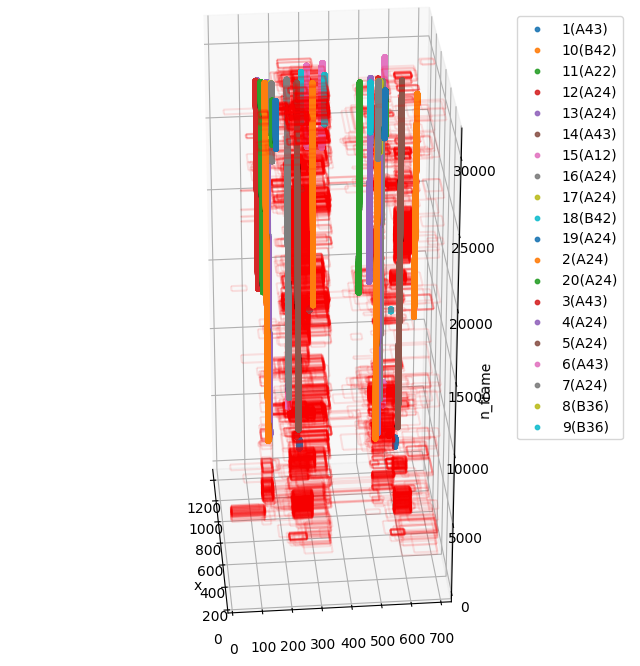

In [4]:
fig = plt.figure(figsize=(8, 12))
ax = fig.add_subplot(111, projection='3d')

# plot yolo
for pred in tqdm(yolo_preds):
    z, x1, y1, x2, y2 = pred[:5].astype(int)
    w, h = x2 - x1, y2 - y1
    conf = pred[5]
    if z % 10 != 0:
        continue
    if w * h > th_size:
        continue
    if conf < th_conf:
        continue
    X, Y = np.mgrid[x1:x2:w-1, y1:y2:h-1]
    Z = np.full(X.shape, z)
    ax.plot_wireframe(X, Y, Z, edgecolor="red", facecolor="white", alpha=0.1, rstride=w, cstride=h)

# plot annotation
for label in np.unique(ann_data.T[8]):
    tmp_data = ann_data[np.where(ann_data.T[8] == label)[0]]
    X = tmp_data.T[5].astype(float)
    Y = tmp_data.T[6].astype(float)
    Z = tmp_data.T[0].astype(int)
    ax.scatter(X, Y, Z, marker="o", label=label, s=10, alpha=0.9)

ax.set_box_aspect((frame_size[0], frame_size[1] * 1.5, frame_size[0] * 2.0))
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('n_frame')
ax.set_xlim(0, frame_size[0])
ax.set_ylim(0, frame_size[1])
ax.set_zlim(0, frame_count)
ax.legend()
plt.gca().invert_xaxis()

# img rotation
imgs = []
for angle in tqdm(range(0, 360, 5)):
    ax.view_init(elev=30, azim=angle)
    fig.canvas.draw()
    img = np.array(fig.canvas.renderer.buffer_rgba())
    img = cv2.cvtColor(img, cv2.COLOR_RGBA2RGB)
    img = img[250:-200, 150:-50]
    imgs.append(img)

# write video
size = imgs[0].shape[1::-1]
wrt = video.Writer(f"out/{video_name}/{video_name}_plot.mp4", 30, size)
wrt.write_each(imgs)
del wrt

plt.show()